In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# import argparse
import os
import random
import shutil
import time
import warnings
import datetime
import sys
import json
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pprint import pprint
import matplotlib.ticker as ticker


os.chdir('./')
# EdMIPS/models ディレクトリへのパスを追加
sys.path.append('./models')
from models.quant_efficientnet import BasicCNNBlock
import models as models

# カレントディレクトリを 'EdMIPS' に変更
os.chdir('.')

device_count = torch.cuda.device_count()
print('Number of devices: {}'.format(device_count))
# setting device
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

Number of devices: 2
True


In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [4]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')
    
    acc1_avg = 0
    acc5_avg = 0
    # switch to evaluate mode
    model.eval()
    model.to(device)

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.to(device)
            target = target.to(device)
            # cifar-10,100のみ
            images = F.interpolate(images,size=(224,224),mode='bicubic')
            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            acc1_avg += float(acc1)
            acc5_avg += float(acc5)
            # check
            # print(f'{i}  acc1:{int(acc1)}  acc5:{int(acc5)}')
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        
    acc1_avg = acc1_avg / len(val_loader)
    acc5_avg = acc5_avg / len(val_loader)
    return acc1_avg , acc5_avg
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            #correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [5]:
def adjust_learning_rate(optimizer, epoch, config):
    """Sets the learning rate to the initial LR decayed by 10 every step_epochs"""
    step_epoch = 10
    lr = config['lr'] * (0.1 ** (epoch // step_epoch))
    # print(f'Learning rate : {lr}')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(train_loader, model, criterion, optimizer, epoch,config):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    curr_lr = optimizer.param_groups[0]['lr']
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}/{}]\t"
               "LR: {}\t".format(epoch, config['epoch'], curr_lr))

    # switch to train mode
    model.train()
    model.to(device)

    
    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        
        images = images.to(device)
        target = target.to(device)
        
        # cifar-10,100のみ
        images = F.interpolate(images,size=(224,224),mode='bicubic')
        
        # compute output
        output = model(images)
        loss = criterion(output, target)
        
        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

In [6]:
def noisy_only_train(train_loader, model, criterion, optimizer, epoch, B, noise_scale , config):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    curr_lr = optimizer.param_groups[0]['lr']
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}/{}]\t"
               "LR: {}\t".format(epoch, config['epoch'], curr_lr))

    # switch to train mode
    model.train()
    model.to(device)

    
    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        images = images.to(device)
        target = target.to(device)
        
        # cifar-10,100のみ
        images = F.interpolate(images,size=(224,224),mode='bicubic')

        laplace_dist =torch.distributions.Laplace(loc = 0, scale = B/noise_scale)
        noisy_images = images + laplace_dist.sample(images.size()).to(device)
        noisy_images = noisy_images.to(device)
        
        # compute output
        
        noisy_output = model(noisy_images)
        loss = criterion(noisy_output, target)
        
        # measure accuracy and record loss
        acc1, acc5 = accuracy(noisy_output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

In [7]:
# ノイズデータとクリーンデータ両方をlossにとって同時に学習
# 多分もう使わなそう
def noisy_train(train_loader, model, criterion, optimizer, epoch, B, noise_scale , config):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    curr_lr = optimizer.param_groups[0]['lr']
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}/{}]\t"
               "LR: {}\t".format(epoch, config['epoch_noisy'], curr_lr))

    # switch to train mode
    model.train()
    model.to(device)

    
    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        images = images.to(device)
        target = target.to(device)
        
        # cifar-10,100のみ
        images = F.interpolate(images,size=(224,224),mode='bicubic')
        
        laplace_dist =torch.distributions.Laplace(loc = 0, scale = B/noise_scale)
        noisy_images = images + laplace_dist.sample(images.size())
        noisy_images = noisy_images.to(device)
        
        # compute output
        
        clean_output = model(images)
        noisy_output = model(noisy_images)
        loss = criterion(clean_output,noisy_output, target)
        
        # measure accuracy and record loss
        acc1, acc5 = accuracy(clean_output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

In [8]:
def find_B(train_loader,model,splitting_points):
    model.to(device)
    model.change_learning_method(False)
    with torch.no_grad():
        for i, (images, target) in enumerate(train_loader):
            images = images.to(device)
            # cifar-10,100のみ
            images = F.interpolate(images,size=(224,224),mode='bicubic')
            model.eval()
            if i==0:
                features_list = torch.stack(model.feature_extractor(images,splitting_points))
            else:
                features = torch.stack(model.feature_extractor(images,splitting_points))
                features_list = torch.cat([features_list,features],dim = 1)
    # check
    print([len(v) for v in features_list])
    
    
    bound_threshold_medi = torch.median(features_list,dim = 1).values
    bound_threshold_mean = torch.mean(features_list,dim = 1)
    
    # check 
    print(f"bound threshold median : {bound_threshold_medi}")
    print(f"bound threshold mean : {bound_threshold_mean}")

    return bound_threshold_medi

In [9]:
def display_imagenet_noise_image(train_loader,noise_scale):
    for i, (images, target) in enumerate(train_loader):
        
        fig, ax = plt.subplots(2,2,figsize = (8,8))
        for j in range(2):
            # cifar-10,100のみ
            images = F.interpolate(images,size=(224,224),mode='bicubic')
            
            img = images[j]
            img.to('cpu')
            laplace_dist =torch.distributions.Laplace(loc = 0, scale = 2.6/noise_scale)
            noisy_img = img + laplace_dist.sample(img.size())
            print(img.size())
            np_img =img.numpy().transpose((1, 2, 0))
            np_noisy_img = noisy_img.numpy().transpose((1, 2, 0))
            
            
            # fig.suptitle(f"{target[0]}")
            ax[j][0].imshow(np_img)
            ax[j][1].imshow(np_noisy_img)
            
            ax[j][0].axes.xaxis.set_visible(False)
            ax[j][1].axes.xaxis.set_visible(False) # X軸を非表示に
            ax[j][0].axes.yaxis.set_visible(False)
            ax[j][1].axes.yaxis.set_visible(False)# Y軸を非表示に
        plt.tight_layout()
        plt.show()
        break

In [10]:
# def noisy_training用
class  Noisy_CrossEntropyLoss(nn.Module):
    def __init__(self,clean_ratio):
        super().__init__()
        self.CrossEntropyLoss = nn.CrossEntropyLoss()
        self.clean_ratio = clean_ratio
    def forward(self,y_clean,y_noisy,y):
        loss = self.clean_ratio*self.CrossEntropyLoss(y_clean,y) + (1-self.clean_ratio)*self.CrossEntropyLoss(y_noisy,y)
        
        return loss
    

In [11]:
def load_cifar10(batch):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    val_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    return train_loader,val_loader
def load_cifar100(batch):
    train_loader = DataLoader(
        datasets.CIFAR100('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    val_loader = DataLoader(
        datasets.CIFAR100('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    return train_loader,val_loader
def load_imagenet100(DATASETDIR,config):
    # Data loading code
    traindir = os.path.join(DATASETDIR, 'train')
    valdir = os.path.join(DATASETDIR , 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    crop_size, short_size = 224, 256


    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    print(f'crop size:{crop_size},short_size:{short_size}')
    train_sampler = None

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], shuffle=(train_sampler is None),
        num_workers=config['workers'], pin_memory=True, 
        sampler=train_sampler)

    val_dataset =datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(short_size),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            normalize,
        ]))
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config['batch_size'], shuffle=False,
        num_workers=config['workers'], pin_memory=True)

    # print(len(train_loader))
    # print(len(val_loader))
    return train_loader,val_loader

In [12]:
# save_name 命名規則
# 学習するデータ(clean or noise)_noise scale_エポック数_データセット名(_日付)
config = {
    'model_name': 'quanteffnet_w8a8_with_DP',
    'batch_size': 50,
    'workers'   : 16,
    'epoch_clean': 0,
    'epoch_noisy': 50,
    'momentum'  : 0.9,
    'weight-decay':1e-4,
    'lr'        : 0.1,
    'noise-scale': 10,
    'save_dir'  : 'efficient_b0_w8a8_imagenet100_with_DP/noise_10_cifar10',
    'save_name' : 'noise_10_50_cifar10',
    'epoch'     : 0  #エラー回避のため
}

DATASETDIR ='~/datasets/imagenet-100'
# 量子精度は決定したけど学習してないアーキテクチャ
mixefnet_dir='./arch_output/mixeffnet_b0_w2468a2468_100_csd0.01_forlossynet/arch_model_best.pth.tar'

In [13]:
# data loading
# train_loader,val_loader = load_imagenet100(DATASETDIR,config)
train_loader,val_loader = load_cifar10(batch=config['batch_size'])
print(len(train_loader),len(val_loader))
print(config['batch_size'])

# check
# display_imagenet_noise_image(train_loader,config['noise-scale'])

Files already downloaded and verified
Files already downloaded and verified
1000 200
50


In [14]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

cudnn.benchmark = True

In [15]:
# create models　最初から学習を始めるため
# model = models.__dict__[config["model_name"]](mixefnet_dir)
# U8
model = models.__dict__[config['model_name']]("")
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), config['lr'],
                                    momentum=config['momentum'],
                                    weight_decay=config['weight-decay'])


model.to(device)
model.change_learning_method(False)

archas: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
archws: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [16]:
acc1_progress = []
acc5_progress = []

acc1,acc5= validate(val_loader, model, criterion)
print(f'----- No Training accuracy ------')
print(f'acc1 : {acc1}  acc5 : {acc5}')

acc1_progress.append(acc1)
acc5_progress.append(acc5)

best_epoch = 0
best_acc1 =acc1
# Clean Training
for epoch in range(config['epoch_clean']):
    adjust_learning_rate(optimizer, epoch, config)
    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch,config)
        
    # evaluate on validation set
    acc1,acc5= validate(val_loader, model, criterion)
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    if is_best:
        best_epoch = epoch
    print(f'----- Clean Training epoch:{epoch+1} accuracy ------')
    print(f'acc1 : {acc1}  acc5 : {acc5}')
    
    acc1_progress.append(acc1)
    acc5_progress.append(acc5)

----- No Training accuracy ------
acc1 : 10.0  acc5 : 50.0


In [17]:
# 一回のみ実行
input_norm_list = []
for i, (images, target) in enumerate(train_loader):
     input_norm = torch.max(torch.flatten(images,1,-1),dim=1).values
     # print(input_norm)
     if i==0:
          input_norm_list = input_norm
     else:
          input_norm_list = torch.cat([input_norm_list,input_norm],dim = 0)
          
B_input = torch.median(input_norm_list)
# # B_input:0.9529(cifar-10)
# # B_input:0.9686(cifar-100)
print(B_input)

tensor(0.9529)


In [18]:
# B_input = 0.9529

# noisy_criterion = Noisy_CrossEntropyLoss(clean_ratio=0.5).to(device)


In [19]:
#  only Noise Data training
for epoch in range(config['epoch_noisy']):
    adjust_learning_rate(optimizer, config['epoch_clean']+epoch, config)
    # train for one epoch
    noisy_only_train(train_loader, model, criterion, optimizer, epoch, B_input , config['noise-scale'], config)
        
    # evaluate on validation set
    acc1,acc5= validate(val_loader, model, criterion)
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    if is_best:
        best_epoch = epoch
    print(f'----- Only Noise Data Training epoch:{epoch+1} accuracy ------')
    print(f'acc1 : {acc1}  acc5 : {acc5}')
    
    acc1_progress.append(acc1)
    acc5_progress.append(acc5)

----- Only Noise Data Training epoch:1 accuracy ------
acc1 : 31.29  acc5 : 87.96
----- Only Noise Data Training epoch:2 accuracy ------
acc1 : 52.32  acc5 : 92.29
----- Only Noise Data Training epoch:3 accuracy ------
acc1 : 71.13  acc5 : 97.55
----- Only Noise Data Training epoch:4 accuracy ------
acc1 : 75.51  acc5 : 98.53
----- Only Noise Data Training epoch:5 accuracy ------
acc1 : 78.26  acc5 : 98.73
----- Only Noise Data Training epoch:6 accuracy ------
acc1 : 81.1  acc5 : 98.91
----- Only Noise Data Training epoch:7 accuracy ------
acc1 : 82.02  acc5 : 99.1
----- Only Noise Data Training epoch:8 accuracy ------
acc1 : 82.57  acc5 : 99.16
----- Only Noise Data Training epoch:9 accuracy ------
acc1 : 82.97  acc5 : 99.21
----- Only Noise Data Training epoch:10 accuracy ------
acc1 : 83.4  acc5 : 98.95
----- Only Noise Data Training epoch:11 accuracy ------
acc1 : 88.18  acc5 : 99.53
----- Only Noise Data Training epoch:12 accuracy ------
acc1 : 88.48  acc5 : 99.52
----- Only Noise

In [20]:
print(acc1_progress)

[10.0, 31.29, 52.32, 71.13, 75.51, 78.26, 81.1, 82.02, 82.57, 82.97, 83.4, 88.18, 88.48, 88.51, 88.51, 88.76, 88.79, 88.7, 89.19, 88.63, 89.1, 88.84, 88.9, 89.15, 89.01, 89.01, 89.04, 89.06, 89.35, 88.99, 88.95, 89.18, 89.19, 89.08, 89.01, 88.85, 89.01, 88.98, 88.97, 88.92, 89.08, 89.12, 89.24, 88.97, 89.17, 89.07, 88.89, 89.08, 89.03, 89.01, 88.93]


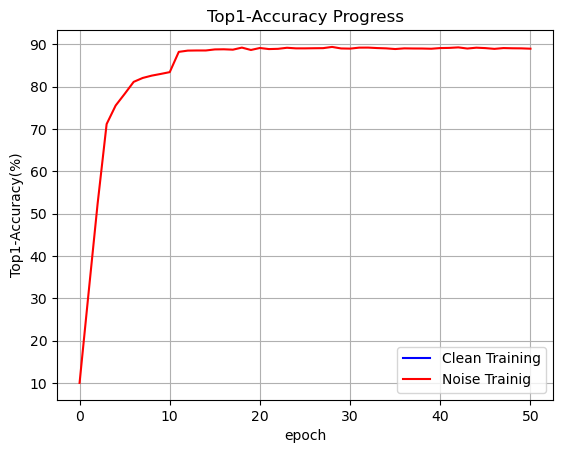

In [21]:
# 可視化
epochs = range(0,config['epoch_clean']+config['epoch_noisy']+1)

plt.plot(epochs[:config['epoch_clean']],acc1_progress[:config['epoch_clean']],color = 'b',label = 'Clean Training')
plt.plot(epochs[config['epoch_clean']:],acc1_progress[config['epoch_clean']:],color = 'r',label = 'Noise Trainig')

# plt.ylim(60,80)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Top1-Accuracy(%)')
plt.title('Top1-Accuracy Progress')
plt.legend()
plt.show()

In [22]:
def save_model(state, epoch, filename='checkpoint.pth.tar',save_dir=datetime.datetime.now().strftime('%y-%m%d_%H%M%S')):
    save = f'./Privacy_Aware_DSC/{save_dir}'
    os.makedirs(save, exist_ok=True)
    torch.save(state, f"{save}/{filename}")

save_model({
    'epoch': epoch + 1,
    'arch': config["model_name"],
    'state_dict': model.state_dict(),
    'best_acc1': best_acc1,
    'optimizer': optimizer.state_dict(),
}, epoch, filename=f"{config['save_name']}_{datetime.datetime.now().strftime('%y%m%d')}.pth.tar",save_dir=config['save_dir'])

In [23]:
print("Experiment Done")
print(datetime.datetime.now().strftime('%Y-%m%d_%H:%M:%S'))

Experiment Done
2024-1116_15:55:16
